# Tests using the new data class

In [1]:
import os
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, "/home/usuario/project/src")

%load_ext autoreload
%autoreload

from dataset import Route

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsPersons',  'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [3]:
dataset_path = os.path.join(datasets_path, all_datasets[0])

In [4]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(dataset_path, "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(dataset_path, "info_eval.csv"))
# Observation means for pc1 and pc2
means1 = np.load(os.path.join(dataset_path, 'observed_mean_pc1.npy'))
means2 = np.load(os.path.join(dataset_path, 'observed_mean_pc2.npy'))
# Observation medians for pc1 and pc2
medians1 = np.load(os.path.join(dataset_path, 'observed_median_pc1.npy'))
medians2 = np.load(os.path.join(dataset_path, 'observed_median_pc2.npy'))

In [5]:
# Angles correction Reduces the MSE from 200 to 66 degrees.
predictions.loc[predictions['pred_angles']>3, 'pred_angles'] = predictions[predictions['pred_angles']>3]['pred_angles'] - 3
predictions.loc[predictions['pred_angles']<-3, 'pred_angles'] = predictions[predictions['pred_angles']<-3]['pred_angles'] + 3

In [6]:
def routes_to_dict(eval_info, predictions, mean1, mean2, median1, median2):
    ''' Loads (meta)info from disk to memory classes for easy manipulation '''
    routes = dict()
    n_routes = eval_info.shape[0]
    
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        n_points = current['n_points']
        current_pred = predictions.iloc[start_i:start_i+n_points]
        
        all_i = current['first_point']
        sliced_mean1 = mean1[all_i:all_i+n_points,:]
        sliced_mean2 = mean2[all_i:all_i+n_points,:]
        sliced_median1 = median1[all_i:all_i+n_points,:]
        sliced_median2 = median2[all_i:all_i+n_points,:]
        sliced_pred1 = predictions.loc[start_i:start_i+n_points-1,['pred_pc1center_x', 'pred_pc1center_y']].values
        sliced_pred2 = predictions.loc[start_i:start_i+n_points-1,['pred_pc2center_x', 'pred_pc2center_y']].values
        
        route_obj = Route(current['name'], current_pred)
        
        # Add the observation to the gt table
        route_obj.add_observation(obs_pc1=sliced_mean1, obs_pc2=sliced_mean2, name="mean")
        route_obj.add_observation(obs_pc1=sliced_median1, obs_pc2=sliced_median2, name="median")
        route_obj.add_observation(obs_pc1=sliced_pred1, obs_pc2=sliced_pred2, name="pred")

        routes[current['name']] = route_obj
            
    return routes

In [7]:
routes_dict = routes_to_dict(eval_info, predictions, mean1=means1, mean2=means2, median1=medians1, median2=medians2)

In [8]:
for key, route in routes_dict.items():
    
    # NN predictions come from neural network! (input data to this script)
    # By default has gt, align3d
    
    # make align3d+kf predictions
    route.run_kalman_filter_align(store_name='kf/align3d', generates_route=False)
    route.run_kalman_filter_means(pos_name="mean", store_name='kf/means', generates_route=True)
    route.run_kalman_filter_means(pos_name="median", store_name='kf/median', generates_route=True)
    route.run_kalman_filter_means(pos_name="pred", store_name='kf/pred', generates_route=True)
    #route.run_kalman_filter_means_align(store_name='kf/align3d+means', generates_route=False)
    route.run_kalman_filter_means_align_xy(pos_name="mean", store_name='kf/align3d+means_xy', generates_route=False)
    route.run_kalman_filter_means_align_xy(pos_name="median", store_name='kf/align3d+median_xy', generates_route=False)
    route.run_kalman_filter_means_align_xy(pos_name="pred", store_name='kf/align3d+pred_xy', generates_route=False)

    # Computes all the routes
    route.compute_routes()
    # Computes all the route errors
    route.compute_all_rmse()

In [10]:
import matplotlib.pyplot as plt
from matplotlib import patches

#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 8, 8

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = 20,10

In [11]:
def plot_route(route, names=None, arrows=False):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    fig, ax = plt.subplots()
    
    colours=['orange', 'red', 'green', 'blue', 'pink', 'yellow', 'cyan']
    
    ax.plot(route.routes['gt_x'], route.routes['gt_y'], '-ok', color='black')
    for i, name in enumerate(names):
        ax.plot(route.routes[f'{name}_x'], route.routes[f'{name}_y'], '-ok', color=colours[i], label=f'{name} RMSE: {route.trans_error[name]:.4f}')
        
        
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))

    ax.legend(prop={'size': 15})

    # Set title to the plot
    ax.set_title(f"route: {route.name}", size=20)
   

In [12]:
def plot_two_route(route, pos_names = None, trans_names=None, arrows=False, save=False):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    
    # Link axis (?)
    #fig, ax = plt.subplots(1, 2, figsize=(20,10),sharex='row', sharey='row')
    fig, ax = plt.subplots(1, 2, figsize=(20,10))


    colours_trans = ['orange', 'red', 'blue', 'magenta','lime', 'purple']

    colours_pos = ['black', 'green', 'pink', 'cyan', 'navy', 'yellow', 'grey']

    # We build two different axis for relative and absolute
    for axis, motion in zip(ax.flat, ['relative', 'absolute']):
        
        # Always plot ground thruth
        for i, name in enumerate(pos_names):
            axis.plot(route.routes[f'{name}_x'], route.routes[f'{name}_y'], '-ok', color=colours_pos[i], label=f'{name} RMSE: {route.trans_error[name]:.4f}')

        # And plot each route on the axis STEP ROUTES
        for i, name in enumerate(trans_names):
            name_var = f'{name}_{motion}'
            axis.plot(route.routes[f'{name_var}_x'], route.routes[f'{name_var}_y'], '-ok', color=colours_trans[i], label=f'{name} RMSE: {route.trans_error[name_var]:.4f}')

        # Set axis and legend to axis
        axis.legend(prop={'size': 15})
        axis.set_title(f"route: {route.name} {motion}", size=20)
        
    
    # TODO: fix arrows
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))
    
    if save:
        fig.savefig(f'./imgs/{route.name}.svg', format='svg', dpi=1200)


In [13]:
i = 20

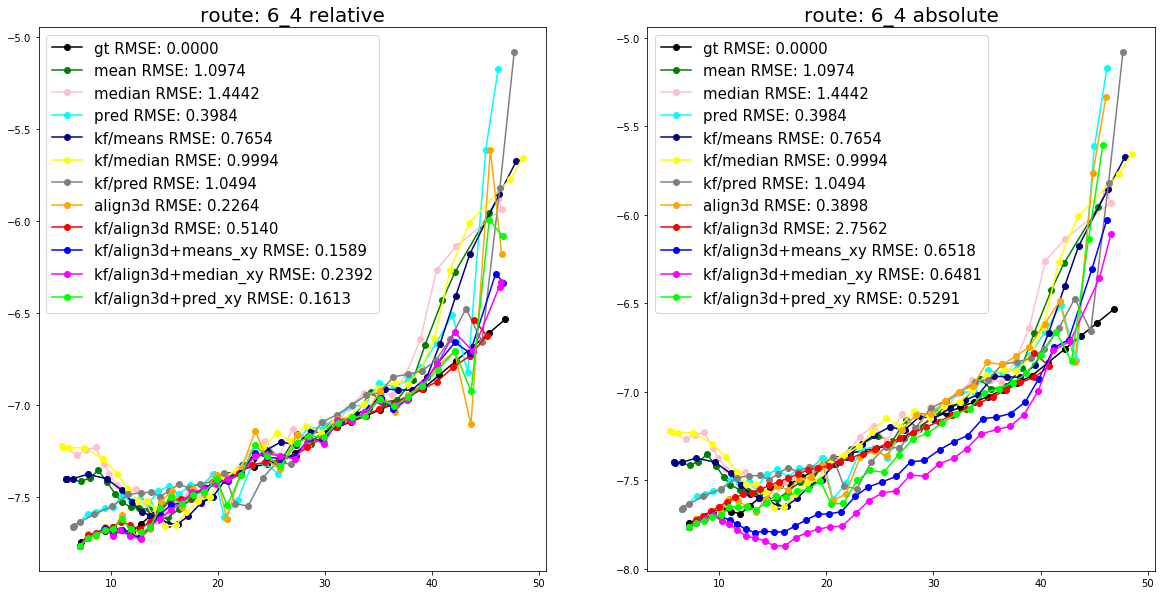

In [14]:
r = routes_dict[list(routes_dict.keys())[i]]
plot_two_route(route=r, pos_names=r.name_routes.position, trans_names=r.name_routes.translation, save=True)
i += 1

In [15]:
import json
from itertools import chain

def export_results(routes_dict):
    ''' Dump rmse to json file '''
    
    route = list(routes_dict.values())[0]
    keys = route.name_routes.position+list(chain.from_iterable([[route+'_relative', route+'_absolute'] for route in route.name_routes.translation]))
    error_dict = {key:0 for key in keys}
    for name, route in routes_dict.items():
        for key in keys: 
            error_dict[key] += route.trans_error[key]

    for key in keys:
        error_dict[key] = error_dict[key]/len(routes_dict)

    jsonf = json.dumps(error_dict, indent=4)    
    f = open("./imgs/results.json","w")
    f.write(jsonf)
    f.close()
    
    return error_dict

In [16]:
res = export_results(routes_dict)

In [17]:
res

{'gt': 0.0,
 'mean': 1.0275221742929896,
 'median': 1.2736251944113672,
 'pred': 0.48684538928223686,
 'kf/means': 2.088926248832907,
 'kf/median': 2.301206992865231,
 'kf/pred': 1.6868318601924748,
 'align3d_relative': 0.17689506167786162,
 'align3d_absolute': 0.8969510263074179,
 'kf/align3d_relative': 1.107984293339355,
 'kf/align3d_absolute': 10.917442546873986,
 'kf/align3d+means_xy_relative': 0.14874608128927094,
 'kf/align3d+means_xy_absolute': 0.7404118020053301,
 'kf/align3d+median_xy_relative': 0.15932322919646874,
 'kf/align3d+median_xy_absolute': 0.7524415493769004,
 'kf/align3d+pred_xy_relative': 0.13317402807768938,
 'kf/align3d+pred_xy_absolute': 0.6779938587148135}